# Análise de concessão de seguros de saúde

### Aqui faço uma análise do conjunto de dados sobre concessão de seguros de saúde, disponível no link: https://www.kaggle.com/mirichoi0218/insurance

## Objetivo: Verificar as relações entre as variveis do conjunto de dados e fazer uma regressão a fim de prever o valor da concessão dada pelo seguro de saúde de individuos de perfil variado

## Variáveis presentes no conjunto de dados(Inglês):
* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance


## Análise:

### Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/home/otavio/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importando os dados e mostrando a estrutura

In [2]:
dataset = pd.read_csv('insurance.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [4]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### A variável alvo é "charges", como pode-se observar trata-se de um dataset com poucas colunas e observações. Temos 3 variáveis categóricas(sex, smoker, region) e as demais numéricas(age, bmi, children, charges) incluindo a variavel alvo. Agora iremos explorar graficamente algumas distribuições das variáveis.

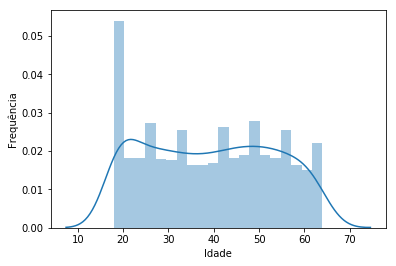

In [5]:
sns.distplot(dataset['age'], bins=20)
plt.ylabel('Frequência')
plt.xlabel('Idade')
plt.show()

### As idades estão uniformemente distribuidas entre 20 e 65 anos , aproximadamente, com pessoas próximas de 20 anos tendo uma frequência um pouco mais elevada do que as demais idades

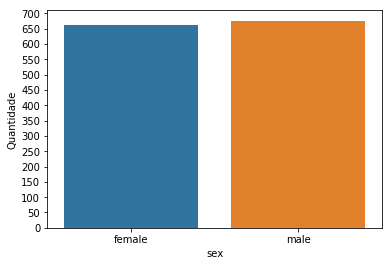

In [6]:
sns.countplot(dataset['sex'])
plt.ylabel('Quantidade')
plt.yticks([i for i in range(0,750,50)])
plt.show()

### Os sexos também parecem estar uniformemente representados, por volta de 650 para cada.

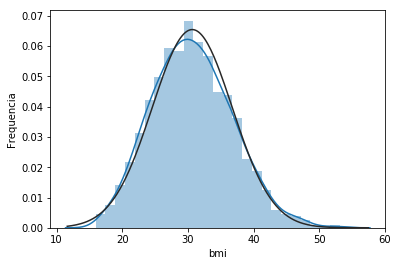

In [7]:
from scipy.stats import norm
sns.distplot(dataset['bmi'], fit=norm)
plt.ylabel('Frequencia')
plt.show()

### Essa distribuição parece familiar? A distribuição do indice de massa corporal se parece muito com a distribuição gaussiana(linha preta)

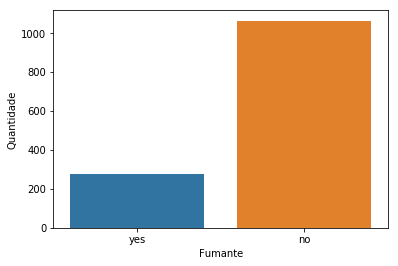

In [8]:
sns.countplot(dataset['smoker'])
plt.ylabel('Quantidade')
plt.xlabel('Fumante')
plt.show()

### Claramente existem bem mais não fumantes no conjunto de dados.

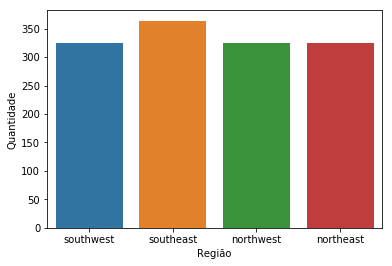

In [9]:
sns.countplot(dataset['region'])
plt.ylabel('Quantidade')
plt.xlabel('Região')
plt.show()

### As Regioẽs estão representadas de forma quase uniforme no conjunto de dados

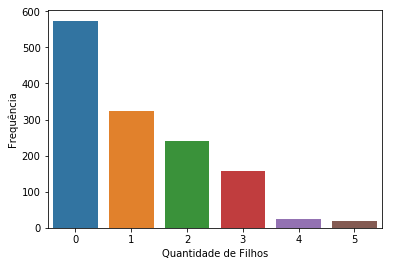

In [10]:
sns.countplot(dataset['children'])
plt.ylabel('Frequência')
plt.xlabel('Quantidade de Filhos')
plt.show()

### Temos muitos pacientes com um ou nenhum filho e poucos com mais de 2, o que era de se esperar.

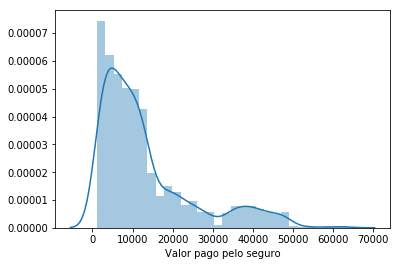

In [11]:
sns.distplot(dataset.charges)
plt.xlabel('Valor pago pelo seguro')
plt.show()

### Os valores parecem concentrar-se principalmente proximo de 10000 unidades monetárias.

## Agora começaremos a visualisar a relação de algumas variáveis com o valor pago pelo seguro de saúde

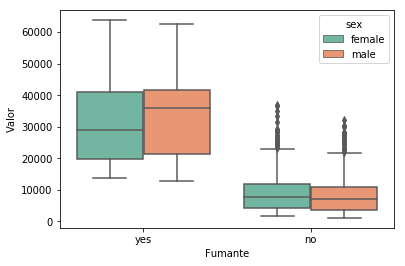

In [12]:
sns.boxplot(x='smoker', y="charges", hue="sex", palette="Set2", data=dataset)
plt.ylabel('Valor')
plt.xlabel('Fumante')
plt.show()

### Este gráfico nos mostra que fumantes custam mais a seguradora independente de sexo. O que é esperado...

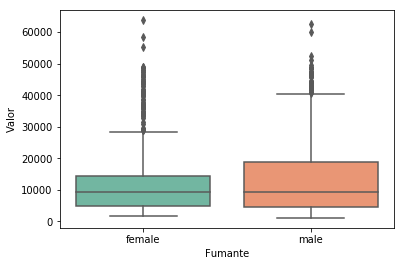

In [13]:
sns.boxplot(x='sex', y="charges" , palette="Set2", data=dataset)
plt.ylabel('Valor')
plt.xlabel('Fumante')
plt.show()

### Homens tem pagamento mais variado do que mulheres

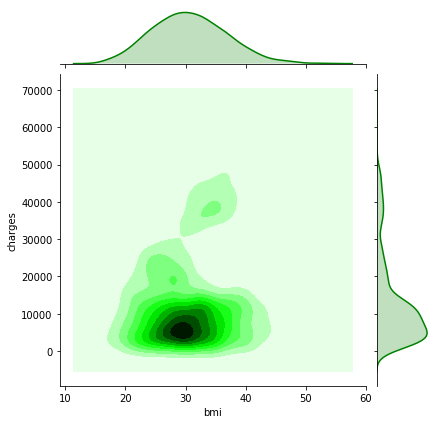

In [14]:
sns.jointplot(dataset.bmi, dataset.charges, color='g', kind='kde')
plt.show()

In [15]:
#Correlação entre 'bmi' e 'charges'
print(np.corrcoef(dataset.bmi.values, dataset.charges.values)[1][0])

0.19834096883362895


### Como podemos observar pelo gráfico e o cálculo acima, bmi e charges não estão correlacionados

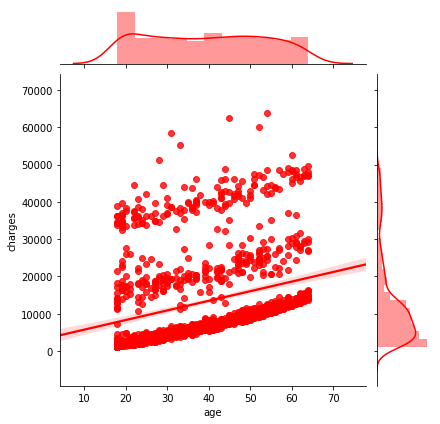

In [16]:
sns.jointplot(dataset.age, dataset.charges, color='r', kind='reg')
plt.show()

In [17]:
#Correlação entre 'age' e 'charges'
print(np.corrcoef(dataset.age.values, dataset.charges.values)[1][0])

0.2990081933306476


### Embora 'age' tenha uma correlação maior com 'charges' , ainda é considerada baixa

## Análise de regressão:
### Agora, passado a análise exploratória, iremos prosseguir para a análise de regressão

### 1) Separando as variaveis e definindo um conjunto de teste:

In [18]:
X = dataset.drop('charges', axis=1)
y = dataset.charges
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### 2) Gerando dummy variables das variaveis categoricas, já que a maioria dos algoritmos só lidam com números:

In [19]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test, drop_first=True)

### 3) Padronizando os dados:

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 4) Escolhendo um algoritmo, treinando e avaliando:

In [21]:
#Primeiro uma regressão linear
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Os Coeficientes
print('Coeficientes: \n', model.coef_)
# O Erro quadrático médio
print("Erro quadrático médio: %.2f"
      % mean_squared_error(y_test, y_pred))
# Variancia Explicada: 1 = 100%
print('R2: %.2f' % r2_score(y_test, y_pred))

Coeficientes: 
 [ 3.57251875e+03  2.07745794e+03  5.28603986e+02 -7.73099946e+00
  9.52373675e+03 -1.10681022e+02 -4.07684444e+02 -3.32163909e+02]
Erro quadrático médio: 31827950.23
R2: 0.80


### Uma simples regressão linear nos retornou um resultado interessante, veremos como algoritmos mais avançados se saem:

In [22]:
#Random Forest Regressor
model2 = RandomForestRegressor(random_state=0)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

# O Erro quadrático médio
print("Erro quadrático médio: %.2f"
      % mean_squared_error(y_test, y_pred))
# Variancia Explicada: 1 = 100%
print('R2: %.2f' % r2_score(y_test, y_pred))

Erro quadrático médio: 21575841.06
R2: 0.86


In [23]:
#XGBoost Regressor
model3 = XGBRegressor(random_state=0)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

# O Erro quadrático médio
print("Erro quadrático médio: %.2f"
      % mean_squared_error(y_test, y_pred))
# Variancia Explicada: 1 = 100%
print('R2: %.2f' % r2_score(y_test, y_pred))

Erro quadrático médio: 16312312.37
R2: 0.90


### Como podemos ver, XGBoost sem nenhum ajuste de Hiperparâmetros performa muito bem! Vamos visualizar os resultados desse modelo de uma melhor forma:

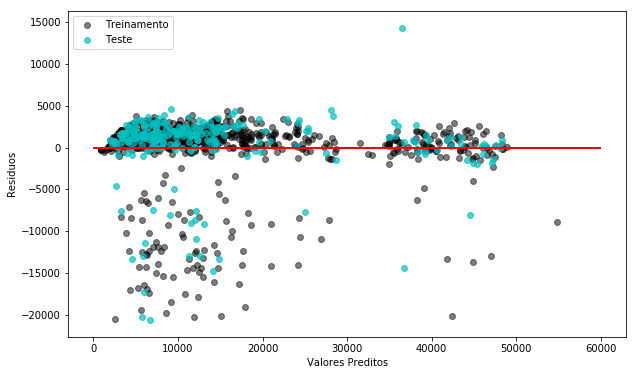

In [24]:
plt.figure(figsize=(10,6))
train_pred = model3.predict(X_train)
plt.scatter(train_pred, train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Treinamento')
plt.scatter(y_pred, y_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Teste')
plt.xlabel('Valores Preditos')
plt.ylabel('Residuos')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

In [25]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/lD76yTC5zxZPG/giphy.gif">')